# Basic Imports

In [1]:
from __future__ import print_function, division
import logging
reload(logging)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s.%(msecs).03d %(name)s %(message)s",
    datefmt='%Y-%m-%dT%H:%M:%S'
)

In [2]:
%matplotlib inline

import pandas
import numpy
from matplotlib import pylab
import seaborn

import ipywidgets as ipyw

In [33]:
import itertools
import toolz.dicttoolz
from toolz.dicttoolz import merge

In [3]:
!git show --oneline -s HEAD

e70f34b Convert protease_sequencing_model to traitlets-based config.


In [7]:
import jug
jug.init("replicate_analysis.py")
import replicate_analysis

In [16]:
from replicate_analysis import replicate_pairs, parameter_sets, model_results, data
model_results = jug.value(model_results)

In [21]:
summary_frames = { d : {} for d in replicate_pairs }

for d, p in itertools.product(replicate_pairs, parameter_sets):
    sframes = []
    for mn in replicate_pairs[d]:
        sf = data.counts[mn].copy()
        sf["ec50"] = model_results[(mn, p)]["sel_ec50"]
        sframes.append(sf)
    
    summary_frames[d][p] = pandas.merge(*sframes, how="inner", on="name")

In [56]:
import scipy.stats

In [66]:
eval_records = [
    merge(
        {
            "pr" : scipy.stats.pearsonr(sf["ec50_x"], sf["ec50_y"])[0],
            "neg_mse" : -mean_squared_error(sf["ec50_x"], sf["ec50_y"]),
        },
        dict(para_set),
        dict(dataset=dataset),
    )
    for dataset in summary_frames
    for para_set, sf in summary_frames[dataset].items()
]

eval_records = pandas.DataFrame.from_records(eval_records)

In [73]:
eval_records.groupby(["dataset"]).apply(lambda df: df.sort_values("neg_mse", ascending=False).head(1))

,,dataset,min_selection_rate,neg_mse,pr,response_fn
dataset,,,,,,
rd2_chymo,7,rd2_chymo,0.05,-1.550434,0.515269,NormalSpaceLogisticResponse
rd2_tryp,14,rd2_tryp,False,-1.838910,0.402108,NormalSpaceLogisticResponse
rd3_chymo,22,rd3_chymo,True,-0.320699,0.873892,LogisticResponse
rd3_tryp,0,rd3_tryp,False,-0.488117,0.830914,LogisticResponse


In [64]:
eval_records

,dataset,min_selection_rate,neg_mse,pr,response_fn
0,rd3_tryp,False,-0.488117,"(0.83091372749, 0.0)",LogisticResponse
1,rd3_tryp,0.05,-0.555025,"(0.81026872691, 0.0)",NormalSpaceLogisticResponse
2,rd3_tryp,False,-0.585594,"(0.784835693793, 0.0)",NormalSpaceLogisticResponse
3,rd3_tryp,0.05,-0.492830,"(0.835759265464, 0.0)",LogisticResponse
4,rd3_tryp,True,-0.489022,"(0.830437158072, 0.0)",LogisticResponse
5,rd3_tryp,True,-0.584639,"(0.785284195627, 0.0)",NormalSpaceLogisticResponse
6,rd2_chymo,False,-2.324894,"(0.561558323089, 0.0)",LogisticResponse
7,rd2_chymo,0.05,-1.550434,"(0.515268892419, 0.0)",NormalSpaceLogisticResponse
8,rd2_chymo,False,-2.653389,"(0.533676701914, 0.0)",NormalSpaceLogisticResponse
9,rd2_chymo,0.05,-1.600707,"(0.535094549285, 0.0)",LogisticResponse


<function __main__.plot_pw>

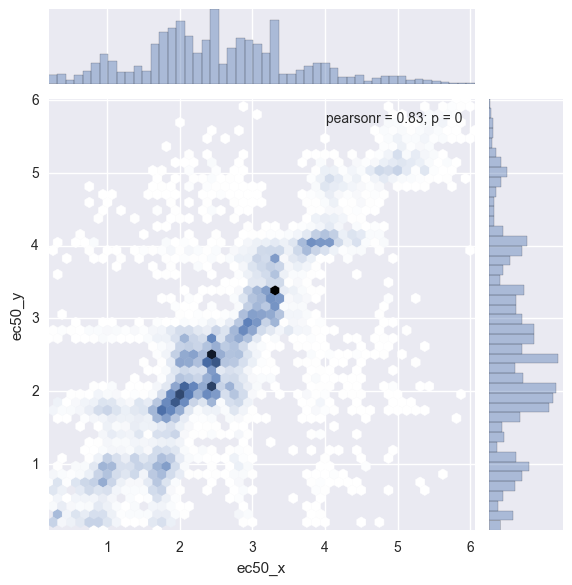

In [62]:
def plot_pw(dataset, params):
    sf = summary_frames[dataset][params]
    seaborn.jointplot(
        "ec50_x", "ec50_y", data=sf,
        kind="hex", joint_kws=dict(mincnt=1),
            
                      
    )
    
ipyw.interact(
    plot_pw,
    dataset=ipyw.Select(options=summary_frames.keys()),
    params=ipyw.Select(options=parameter_sets)
)